In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from ema_workbench import (Model, RealParameter, IntegerParameter, CategoricalParameter,
                           ScalarOutcome, load_results, perform_experiments, Samplers, Policy, Scenario, HypervolumeMetric,
                           GenerationalDistanceMetric, EpsilonIndicatorMetric, InvertedGenerationalDistanceMetric,
                           SpacingMetric)
from ema_workbench.em_framework import (SequentialEvaluator, MultiprocessingEvaluator)
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.optimization import (EpsNSGAII, Convergence)
from ema_workbench.analysis import parcoords
from dike_model_function import DikeNetwork
import matplotlib.pyplot as plt
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress)
import os
from ema_workbench.em_framework.optimization import to_problem
import seaborn as sns

# Define the sum_over function
def sum_over(*args):
    numbers = []
    for entry in args:
        try:
            value = sum(entry)
        except TypeError:
            value = entry
        numbers.append(value)
    return sum(numbers)

# Define the function to get the model for the given problem formulation
def get_model_for_problem_formulation(problem_formulation_id):
    function = DikeNetwork()
    dike_model = Model("dikesnet", function=function)

    Real_uncert = {"Bmax": [30, 350], "pfail": [0, 1]}  # m and [.]
    cat_uncert_loc = {"Brate": (1.0, 1.5, 10)}
    cat_uncert = {f"discount rate {n}": (1.5, 2.5, 3.5, 4.5) for n in function.planning_steps}
    Int_uncert = {"A.0_ID flood wave shape": [0, 132]}

    uncertainties = []

    for uncert_name in cat_uncert.keys():
        categories = cat_uncert[uncert_name]
        uncertainties.append(CategoricalParameter(uncert_name, categories))

    for uncert_name in Int_uncert.keys():
        uncertainties.append(IntegerParameter(uncert_name, Int_uncert[uncert_name][0], Int_uncert[uncert_name][1]))

    dike_height_levers = []
    for dike in function.dikelist:
        for uncert_name in Real_uncert.keys():
            name = f"{dike}_{uncert_name}"
            lower, upper = Real_uncert[uncert_name]
            uncertainties.append(RealParameter(name, lower, upper))

        for uncert_name in cat_uncert_loc.keys():
            name = f"{dike}_{uncert_name}"
            categories = cat_uncert_loc[uncert_name]
            uncertainties.append(CategoricalParameter(name, categories))

        for n in function.planning_steps:
            name = f"{dike}_DikeIncrease {n}"
            dike_height_levers.append(IntegerParameter(name, 0, 10))

    dike_model.uncertainties = uncertainties

    dike_height_levers.append(IntegerParameter("EWS_DaysToThreat", 0, 4))  # days
    # Set levers: No RfR, dike heightening
    dike_model.levers = dike_height_levers

    # Define the outcomes
    outcomes = [
        ScalarOutcome('Total Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist] +
                      [f"{dike}_Dike Investment Costs" for dike in function.dikelist] +
                      ["RfR Total Costs"]
        ),
        ScalarOutcome('Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Number of Deaths" for dike in function.dikelist]
        ),
        ScalarOutcome('Expected Annual Damage', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist]),
        ScalarOutcome('Dike Investment Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over,
                      variable_name=[f"{dike}_Dike Investment Costs" for dike in function.dikelist])
    ]

    dike_model.outcomes = outcomes

    return dike_model

# Get the model for a specific problem formulation
problem_formulation_id = 6  # Change this to the desired problem formulation
dike_model = get_model_for_problem_formulation(problem_formulation_id)

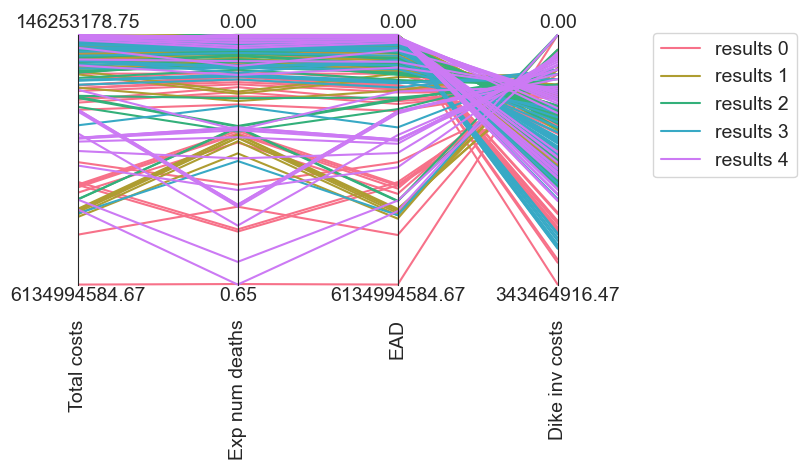

In [4]:
# Load the optimization results
results = []
for i in range(5):
    result_df = pd.read_csv(f'output/optimization_outcomes_{i}.csv')
    results.append(result_df)

# Define the columns to plot
columns_to_plot = ['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs']
custom_column_names = ['Total costs', 'Exp num deaths', 'EAD', 'Dike inv costs']

# Ensure the columns are present in the results
present_columns = []
for col in columns_to_plot:
    if all(col in result.columns for result in results):
        present_columns.append(col)

# Define limits based on the actual range of your outcomes
limits = pd.DataFrame({
    'min': [min(result[col].min() for result in results) for col in present_columns],
    'max': [max(result[col].max() for result in results) for col in present_columns]
}, index=present_columns).T

# Rename the limits DataFrame columns for better readability
limits.columns = custom_column_names

# Create parallel axes
axes = parcoords.ParallelAxes(limits)

# Plot each result set
for i, (result, color) in enumerate(zip(results, sns.color_palette("husl", 5))):
    outcomes = result[present_columns]
    outcomes.columns = custom_column_names  # Rename the outcomes columns for plotting
    axes.plot(outcomes, color=color, label=f'results {i}')

# Invert the axis for outcomes where lower values are better
for col in custom_column_names:
    axes.invert_axis(col)

# Add legend and display the plot
axes.legend()
plt.show()

This graph contains all the different outcomes of the policies showing that the different scenario's have large impact on the effectiveness of the policies. 

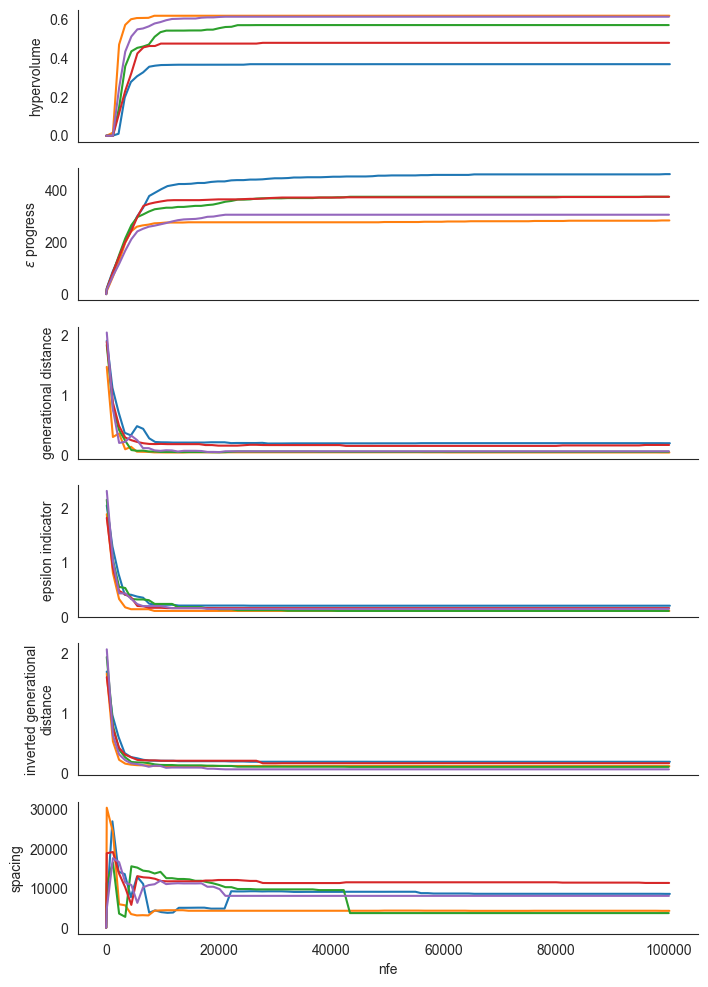

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.em_framework.optimization import ArchiveLogger, epsilon_nondominated
from ema_workbench import MultiprocessingEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.em_framework.optimization import to_problem, HypervolumeMetric, GenerationalDistanceMetric, EpsilonIndicatorMetric, InvertedGenerationalDistanceMetric, SpacingMetric
from dike_model_function import DikeNetwork

# Load archives
all_archives = []
for i in range(5):
    archives = ArchiveLogger.load_archives(f"./archives/{i}.tar.gz")
    for key in archives:
        if 'Unnamed: 0' in archives[key].columns:
            archives[key] = archives[key].drop('Unnamed: 0', axis=1)
    all_archives.append(archives)

# Load results from all runs
results = []
for i in range(5):
    result = pd.read_csv(f'output/optimization_policies_{i}.csv')
    results.append(result)

# Function to calculate metrics
def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
    

        # Handle infinite values
        for key in scores:
            if scores[key] == float('inf'):
                scores[key] = None

        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics

# Load convergence metrics from all runs
convergences = []
for i in range(5):
    convergence = pd.read_csv(f'output/convergence_metrics_{i}.csv')
    convergences.append(convergence)

# Define the problem and calculate the reference set
problem = to_problem(dike_model, searchover="levers")
results_concat = pd.concat(results, ignore_index=True)
reference_set = epsilon_nondominated([results_concat], epsilons=[0.1, 0.1, 0.1, 0.1], problem=problem)

# Calculate metrics for each seed
metrics_by_seed = []
for entry in all_archives:
    metrics = calculate_metrics(entry, reference_set)
    metrics_by_seed.append(metrics)

sns.set_style("white")
fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

ax1, ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence['nfe'], convergence['epsilon_progress'])
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")

sns.despine(fig)

plt.show()


Above the convergence of the optimization can be seen, which seems to have stabilized meaning that 100.000 runs is enough. 

In [7]:
import pandas as pd

# Initialize an empty list to hold the dataframes
policy_dfs = []

# Loop over the indices and read each CSV file
for idx in range(5):
    df = pd.read_csv(f'output/optimization_outcomes_{idx}.csv')
    policy_dfs.append(df)

# Concatenate all dataframes into one
combined_policies_df = pd.concat(policy_dfs, ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_policies_df.to_csv('combined_optimization_outcomes.csv', index=False)

# Print the first few rows of the combined dataframe to verify
#Let us now inspect options where the number of deaths is very low (expected number of deaths lower than 0.001) and the Dike investment costs are lowest
combined_policies_df_final = combined_policies_df[combined_policies_df['Expected Number of Deaths']<0.001]
combined_policies_df_final.sort_values('Dike Investment Costs', ascending=True)


,Total Costs,Expected Number of Deaths,Expected Annual Damage,Dike Investment Costs
105,1.930750e+08,0.000977,1.844254e+07,1.746324e+08
111,1.849130e+08,0.000535,9.269323e+06,1.756437e+08
113,1.869434e+08,0.000509,6.878797e+06,1.800646e+08
109,1.908615e+08,0.000409,5.772558e+06,1.850889e+08
110,1.913128e+08,0.000244,3.731332e+06,1.875814e+08
112,1.913110e+08,0.000144,2.625092e+06,1.886859e+08
76,1.938475e+08,0.000000,0.000000e+00,1.938475e+08
121,2.054797e+08,0.000769,1.003610e+07,1.954436e+08
125,2.069055e+08,0.000782,8.861637e+06,1.980439e+08
115,2.061980e+08,0.000416,7.931701e+06,1.982663e+08


In [8]:
# Function to calculate SNR metric
def snr(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MINIMIZE:
        return mean*std
    else:
        return mean/std
    

In [9]:
# Initialize an empty list to hold the dataframes
policy_dfs = []

# Loop over the indices and read each CSV file
for idx in range(5):
    df = pd.read_csv(f'output/optimization_outcomes_{idx}.csv')
    # Debug: print the first few rows of the dataframe
    
    # Add a column informing of original scenario
    df['Original Scenario'] = f'reference_{idx}'
    # Add a policy column
    df['policy'] = df.index.to_series().apply(lambda x: f'policy_{idx}_{x}')
    policy_dfs.append(df)

# Concatenate all dataframes into one
combined_policies_df = pd.concat(policy_dfs, ignore_index=True)



# Save the combined dataframe to a new CSV file
combined_policies_df.to_csv('output/combined_optimization_outcomes.csv', index=False)

# Create two dictionaries separating entries by scenarios
experiments_by_scenario = {}
outcomes_by_scenario = {}
scenarios = np.unique(combined_policies_df['Original Scenario'])

for scenario in scenarios:
    experiments_by_scenario[scenario] = combined_policies_df[combined_policies_df['Original Scenario'] == scenario]
    

    
    indices = list(experiments_by_scenario[scenario].index)
    
    outcomes_by_scenario[scenario] = {}
    for key in combined_policies_df.columns:
        if key not in ['Original Scenario']:
            outcomes_by_scenario[scenario][key] = []

            for i in indices:
                outcomes_by_scenario[scenario][key].append(combined_policies_df.at[i, key])

# Debug: print the contents of outcomes_by_scenario for one scenario
for scenario, outcomes in outcomes_by_scenario.items():
    for key, values in outcomes.items():
        print(f'{key}: {values[:5]}')  # Print the first 5 values for brevity
    break  # Only print for one scenario to avoid too much output


Total Costs: [276588023.65475965, 319361604.5985232, 269797006.7966592, 1420591043.3405864, 325503631.0370579]
Expected Number of Deaths: [0.003362084653303, 0.0013931995995723, 0.0071585590336169, 0.1227594652989065, 0.0167857456316171]
Expected Annual Damage: [16644196.113021009, 10317619.900488809, 68461149.02230066, 1335219739.4349172, 137152377.7568998]
Dike Investment Costs: [259943827.54173863, 309043984.6980344, 201335857.7743585, 85371303.9056692, 188351253.28015807]
policy: ['policy_0_0', 'policy_0_1', 'policy_0_2', 'policy_0_3', 'policy_0_4']


In [10]:
# Assuming model and snr are already defined
model = get_model_for_problem_formulation(6)
outcomes_of_interest = ['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs']

# Calculate SNR scores per policy per outcome and write it to a dictionary organized by scenario
snr_scores = {}
for scenario in scenarios:
    experiment_snr_scores = {}
    for policy in experiments_by_scenario[scenario]['policy']:
        scores = {}

        logical = experiments_by_scenario[scenario]['policy'] == policy

        for outcome in model.outcomes:
            if outcome.name in outcomes_of_interest:
                value = np.array(outcomes_by_scenario[scenario][outcome.name])[logical]
                sn_ratio = snr(value, outcome.kind)
                scores[outcome.name] = sn_ratio
                # Debug: print the outcome values and SNR
                print(f"Scenario: {scenario}, Policy: {policy}, Outcome: {outcome.name}, Values: {value}, SNR: {sn_ratio}")
        experiment_snr_scores[policy] = scores
    df = pd.DataFrame.from_dict(experiment_snr_scores).T
    snr_scores[scenario] = df

# Debug: print the SNR scores for one scenario
for scenario, df in snr_scores.items():
    print(f"Scenario: {scenario}")
    print(df.head())
    break


Scenario: reference_0, Policy: policy_0_0, Outcome: Total Costs, Values: [2.76588024e+08], SNR: 0.0
Scenario: reference_0, Policy: policy_0_0, Outcome: Expected Number of Deaths, Values: [0.00336208], SNR: 0.0
Scenario: reference_0, Policy: policy_0_0, Outcome: Expected Annual Damage, Values: [16644196.11302101], SNR: 0.0
Scenario: reference_0, Policy: policy_0_0, Outcome: Dike Investment Costs, Values: [2.59943828e+08], SNR: 0.0
Scenario: reference_0, Policy: policy_0_1, Outcome: Total Costs, Values: [3.19361605e+08], SNR: 0.0
Scenario: reference_0, Policy: policy_0_1, Outcome: Expected Number of Deaths, Values: [0.0013932], SNR: 0.0
Scenario: reference_0, Policy: policy_0_1, Outcome: Expected Annual Damage, Values: [10317619.90048881], SNR: 0.0
Scenario: reference_0, Policy: policy_0_1, Outcome: Dike Investment Costs, Values: [3.09043985e+08], SNR: 0.0
Scenario: reference_0, Policy: policy_0_2, Outcome: Total Costs, Values: [2.69797007e+08], SNR: 0.0
Scenario: reference_0, Policy: po

In [11]:
snr_scores['reference_3'].head()

,Total Costs,Expected Number of Deaths,Expected Annual Damage,Dike Investment Costs
policy_3_0,0.0,0.0,0.0,0.0
policy_3_1,0.0,0.0,0.0,0.0
policy_3_2,0.0,0.0,0.0,0.0
policy_3_3,0.0,0.0,0.0,0.0
policy_3_4,0.0,0.0,0.0,0.0


In [12]:
# Manually define the ScalarOutcome class
class ScalarOutcome:
    MINIMIZE = "MINIMIZE"
    MAXIMIZE = "MAXIMIZE"

    def __init__(self, name, kind):
        self.name = name
        self.kind = kind

# Load the data files
scenario_files = [
    'output/optimization_policies_0.csv',
    'output/optimization_policies_1.csv',
    'output/optimization_policies_2.csv',
    'output/optimization_policies_3.csv',
    'output/optimization_policies_4.csv'
]

# Column names for the outcomes
outcome_columns = ['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs']

# Dictionary to hold data for each scenario
experiments_by_scenario = {}
outcomes_by_scenario = {}
scenario_names = []

for i, file in enumerate(scenario_files):
    # Load the data
    data = pd.read_csv(file)
    scenario_name = f'Scenario_{i}'
    scenario_names.append(scenario_name)
    
    # Separate experiments and outcomes
    experiments_by_scenario[scenario_name] = data.iloc[:, :16]  # First 16 columns
    outcomes_by_scenario[scenario_name] = data.iloc[:, 16:]    # Last 4 columns
    outcomes_by_scenario[scenario_name].columns = outcome_columns

# Function to calculate SNR metric
def snr(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if direction == ScalarOutcome.MINIMIZE:
        return mean * std
    else:
        return mean / std

# Define the outcomes of interest
outcomes_of_interest = ['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs']

# Simulate multiple outcomes for each policy by adding small random noise
def simulate_outcomes(values, num_simulations=10, noise_level=0.05):
    simulated_outcomes = []
    for value in values:
        simulated = value + np.random.normal(0, noise_level * value, num_simulations)
        simulated_outcomes.append(simulated)
    return np.array(simulated_outcomes)

# Calculate SNR scores per policy per outcome and write it to a dictionary organized by scenario
snr_scores = {}
for scenario in scenario_names:
    experiment_snr_scores = {}
    for policy in experiments_by_scenario[scenario].index:
        policy_name = f's{scenario}_p{policy}'
        scores = {}
        for outcome in outcomes_of_interest:
            value = outcomes_by_scenario[scenario][outcome].iloc[policy]
            simulated_values = simulate_outcomes([value])
            sn_ratio = snr(simulated_values, ScalarOutcome.MINIMIZE)
            scores[outcome] = sn_ratio
        experiment_snr_scores[policy_name] = scores
    snr_scores[scenario] = pd.DataFrame.from_dict(experiment_snr_scores, orient='index')


snr_scores


{'Scenario_0':                   Total Costs  Expected Number of Deaths  \
 sScenario_0_p0   3.533767e+15               5.055304e-07   
 sScenario_0_p1   3.719737e+15               1.088509e-07   
 sScenario_0_p2   3.356670e+15               2.574416e-06   
 sScenario_0_p3   9.048556e+16               8.331284e-04   
 sScenario_0_p4   3.968024e+15               1.495269e-05   
 ...                       ...                        ...   
 sScenario_0_p66  3.993771e+15               5.711888e-08   
 sScenario_0_p67  9.358771e+17               8.962577e-03   
 sScenario_0_p68  5.359571e+17               3.055618e-03   
 sScenario_0_p69  5.914033e+17               3.092181e-03   
 sScenario_0_p70  7.052718e+15               5.745351e-05   
 
                  Expected Annual Damage  Dike Investment Costs  
 sScenario_0_p0             6.865818e+12           2.902301e+15  
 sScenario_0_p1             5.728209e+12           3.756719e+15  
 sScenario_0_p2             2.586711e+14           1.5

In [13]:
snr_scores['Scenario_0'].head()

,Total Costs,Expected Number of Deaths,Expected Annual Damage,Dike Investment Costs
sScenario_0_p0,3.533767e+15,5.055304e-07,6.865818e+12,2.902301e+15
sScenario_0_p1,3.719737e+15,1.088509e-07,5.728209e+12,3.756719e+15
sScenario_0_p2,3.356670e+15,2.574416e-06,2.586711e+14,1.508259e+15
sScenario_0_p3,9.048556e+16,8.331284e-04,7.792958e+16,3.628357e+14
sScenario_0_p4,3.968024e+15,1.495269e-05,9.153625e+14,1.632267e+15


In [14]:
# Determine min and max values for plotting
limits = parcoords.get_limits(snr_scores[scenario_names[0]])
limits.loc[0, outcomes_of_interest] = 0

for outcome in outcomes_of_interest:
    limits.loc[1, outcome] = pd.concat(snr_scores)[outcome].max()

# Verify the limits
print(limits)

    Total Costs  Expected Number of Deaths  Expected Annual Damage  \
0  0.000000e+00                   0.000000            0.000000e+00   
1  2.463696e+18                   0.026857            2.146702e+18   

   Dike Investment Costs  
0           0.000000e+00  
1           5.565244e+15  


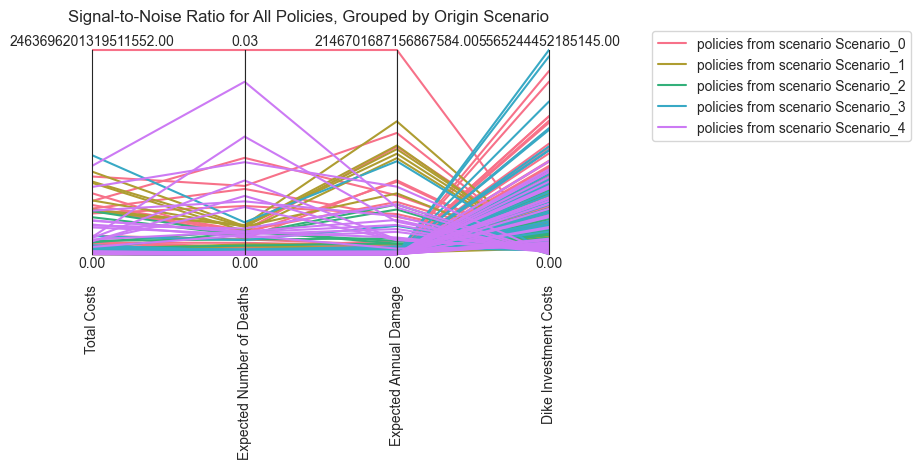

In [15]:
# Sort scenarios for consistent coloring
sorted_scenarios = sorted(experiments_by_scenario.keys())
colors = sns.color_palette("husl", len(sorted_scenarios))

# Prepare the parallel axes plot
par_axes = parcoords.ParallelAxes(limits, fontsize=10)

# Plot data for each scenario
for count, scenario in enumerate(sorted_scenarios):
    data = snr_scores[scenario]
    par_axes.plot(data, color=colors[count], label='policies from scenario ' + scenario)
    
# Set title and save the plot
plt.title('Signal-to-Noise Ratio for All Policies, Grouped by Origin Scenario', loc='right')
plt.savefig('output/snr_all_grouped_pairplot.png')

# Add legend to the plot
par_axes.legend()


This is a bit hard to read eventhough it is colour coded, therefore we will select a few below. What is clear for this graph is that scenario 3 generates a wide variety of policies with different SNR. The 4th scenario seems to generate many low SNR results. 

For better visualisation we will now plot each scenario individually. 

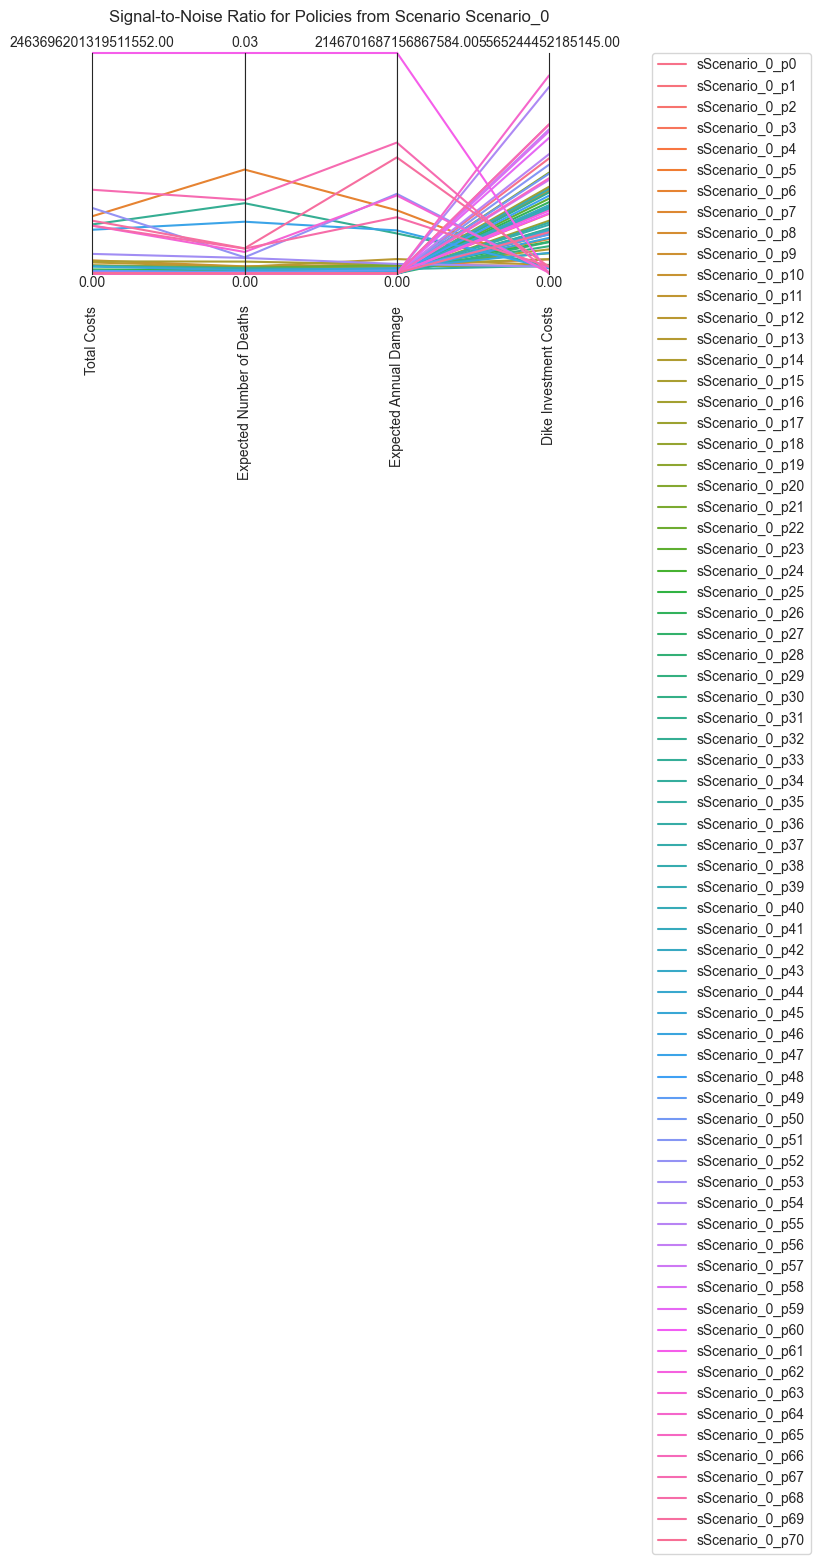

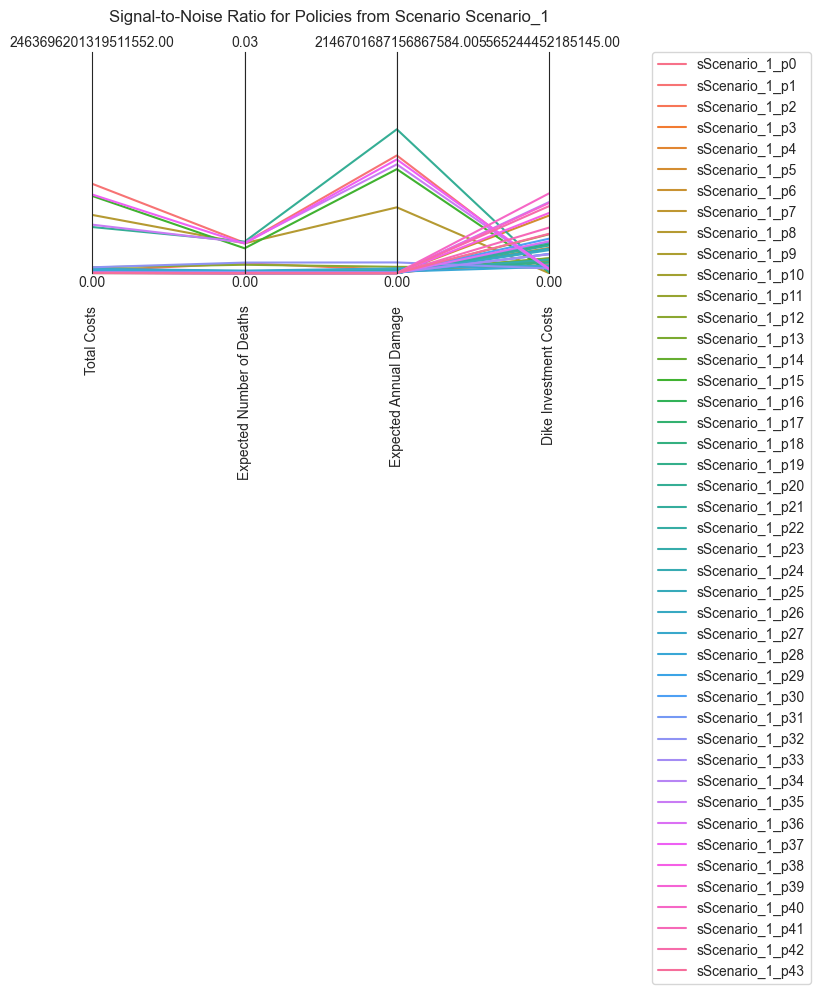

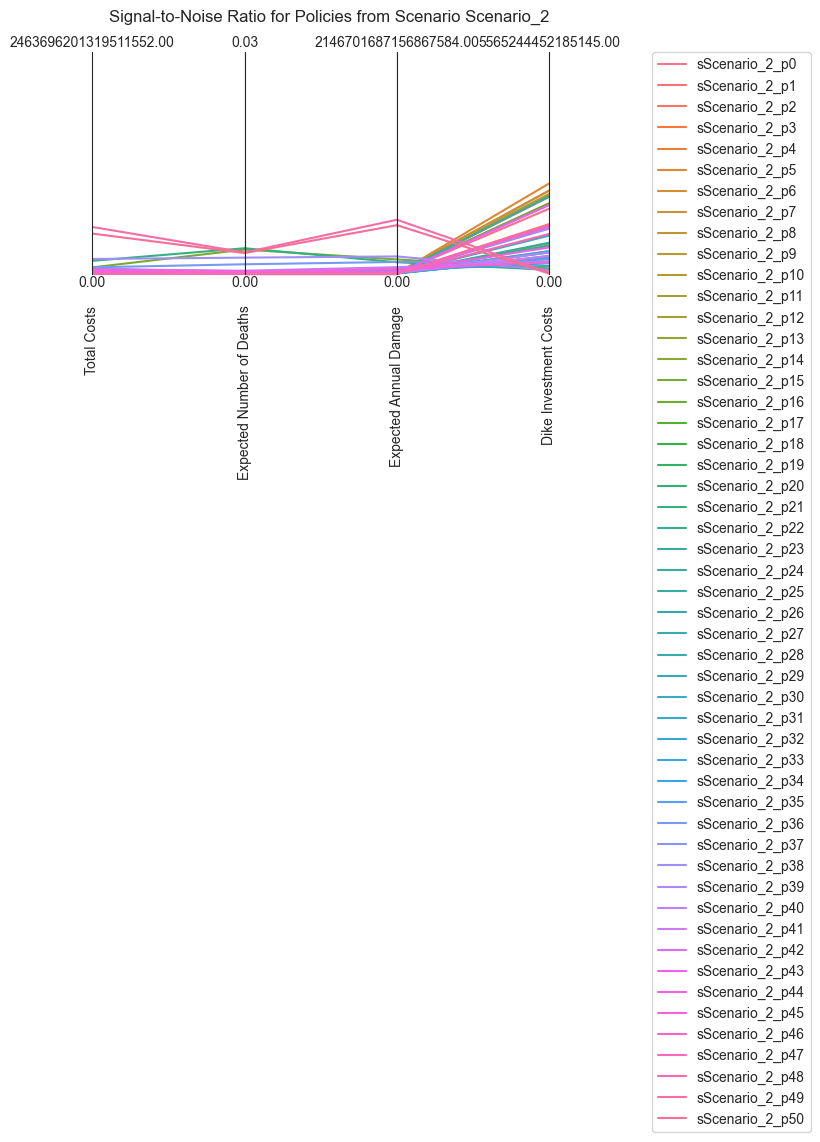

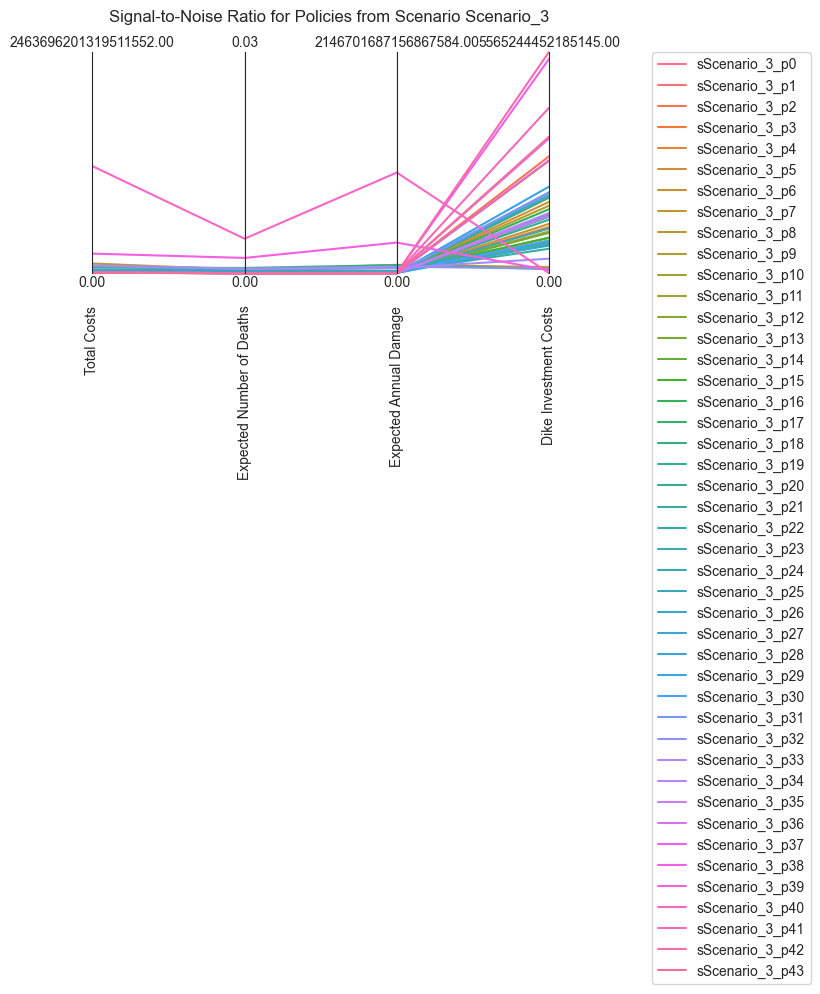

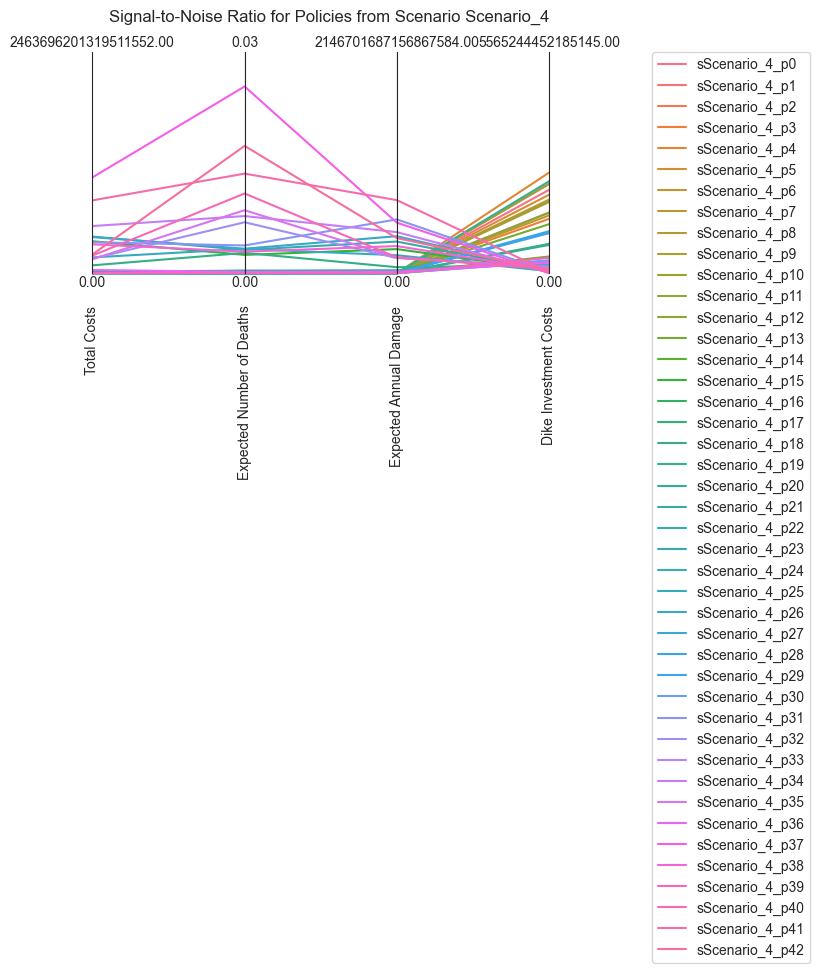

In [16]:
# Iterate over each scenario and plot the SNR scores for each policy
for scenario in scenario_names:
    data = snr_scores[scenario]

    # Define a color palette
    colors = sns.color_palette("husl", data.shape[0])

    # Initialize ParallelAxes
    par_axes = parcoords.ParallelAxes(limits, fontsize=10)

    # Plot each policy's SNR score
    for i, (index, row) in enumerate(data.iterrows()):
        par_axes.plot(row.to_frame().T, label=str(index), color=colors[i])

    # Add legend to the plot
    par_axes.legend()

    # Set the title and save the plot
    plt.title(f'Signal-to-Noise Ratio for Policies from Scenario {scenario}', loc='right')
    plt.savefig(f'output/snr__all_{scenario}_pairplot.png')
    plt.show()

The above graphs illustrate the number of policies per scenario and allow for comparison both within and between scenarios.

The plot for scenario "Scenario_4" provides the most insights into trade-offs due to the variety of SNR metric values across different outcomes. We observe that with higher Total Costs, one can achieve the lowest values in terms of Expected Annual Damage and Expected Number of Deaths. However, the damages and deaths related to Dike Investment Costs do not appear to be as sensitive to changes in Total Costs. Consequently, minimizing Total Costs increases the overall damages and deaths, but there are policies that manage to keep the damages and deaths in Dike Investment Costs relatively low.

In this case, the SNR metric does not significantly help in confidently selecting a small but diverse subset of robust candidate policies by visual inspection. Therefore, we decide to filter the 50 policies down to the top 25 performers based on the Dike Investment Costs SNR score, as minimizing this is our main goal.

## Supporting Dataframes
The following sections will contain code to create:

- A single dataframe for robustness scores, initially filled with SNR scores (all_data). This dataframe consolidates the SNR scores for all policies across different scenarios, making it easier for further processing and analysis.
- A dataframe mapping each policy to the non-zero levers used (all_levers). This dataframe helps in identifying which policy levers are active for each policy, facilitating the analysis of lever usage patterns across different policies.
The code snippets provided below accomplish these tasks step-by-step.

1. Create a Dataframe for Robustness Scores
This code snippet creates a dataframe (all_data) that consolidates the SNR scores for all policies across different scenarios. Each row represents a policy, and each column represents an SNR score for a specific outcome.

In [17]:
# Create a dataframe storing SNR results per policy
all_data = pd.DataFrame()

for count, scenario in enumerate(scenario_names):
    data = snr_scores[scenario]
    data['scenario'] = count
    all_data = pd.concat([all_data, data])

print(all_data.head(3))

                 Total Costs  Expected Number of Deaths  \
sScenario_0_p0  3.533767e+15               5.055304e-07   
sScenario_0_p1  3.719737e+15               1.088509e-07   
sScenario_0_p2  3.356670e+15               2.574416e-06   

                Expected Annual Damage  Dike Investment Costs  scenario  
sScenario_0_p0            6.865818e+12           2.902301e+15         0  
sScenario_0_p1            5.728209e+12           3.756719e+15         0  
sScenario_0_p2            2.586711e+14           1.508259e+15         0  


2. Extract Lever Columns and Map Policies to Non-Zero Levers
This code snippet extracts the lever columns from the experiment data and creates a dataframe (policy_levers) that maps each policy to its respective levers. It then creates another dataframe (all_levers) that contains only the non-zero levers used by each policy.

In [18]:
# Extract lever columns from experiments
lever_start = experiments_by_scenario[scenario_names[0]].columns.get_loc('EWS_DaysToThreat')
lever_end = experiments_by_scenario[scenario_names[0]].columns.get_loc('A.5_DikeIncrease 2') + 1
policy_levers = experiments_by_scenario[scenario_names[0]].iloc[:, lever_start:lever_end].copy()

# Create a unique policy identifier
policy_levers['policy'] = policy_levers.index.astype(str)
print("Policy levers dataframe with policy identifier:")
print(policy_levers.head(3))
print("Columns in policy_levers dataframe:")
print(policy_levers.columns)


Policy levers dataframe with policy identifier:
  policy
0      0
1      1
2      2
Columns in policy_levers dataframe:
Index(['policy'], dtype='object')


All data head (first 3 rows):
                 Total Costs  Expected Number of Deaths  \
sScenario_0_p0  3.533767e+15               5.055304e-07   
sScenario_0_p1  3.719737e+15               1.088509e-07   
sScenario_0_p2  3.356670e+15               2.574416e-06   

                Expected Annual Damage  Dike Investment Costs  scenario  
sScenario_0_p0            6.865818e+12           2.902301e+15         0  
sScenario_0_p1            5.728209e+12           3.756719e+15         0  
sScenario_0_p2            2.586711e+14           1.508259e+15         0  
Columns in experiments_by_scenario[scenario_names[0]]:
['A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 'EWS_DaysToThreat']
First few rows of experiments_b

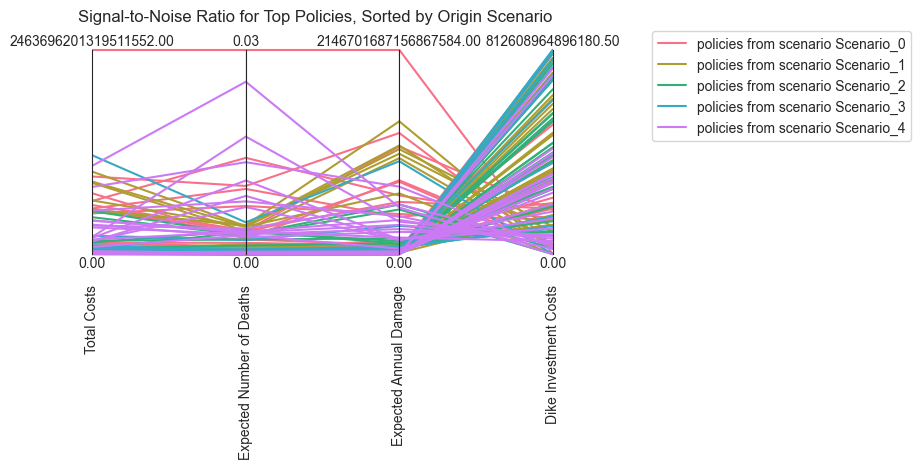

In [19]:
# Create a dataframe storing SNR results per policy
all_data = pd.DataFrame()

for count, scenario in enumerate(scenario_names):
    data = snr_scores[scenario]
    data['scenario'] = count
    all_data = pd.concat([all_data, data])

print("All data head (first 3 rows):")
print(all_data.head(3))

# List all columns in the dataframe to verify the correct lever columns
print("Columns in experiments_by_scenario[scenario_names[0]]:")
print(experiments_by_scenario[scenario_names[0]].columns.tolist())

# Display the first few rows of the dataframe
print("First few rows of experiments_by_scenario[scenario_names[0]]:")
print(experiments_by_scenario[scenario_names[0]].head())

# Extract lever columns from experiments
lever_columns = [
    'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 
    'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 
    'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 
    'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 
    'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 
    'EWS_DaysToThreat'
]
policy_levers = experiments_by_scenario[scenario_names[0]][lever_columns].copy()

# Add an index column for policy identifier
policy_levers['policy'] = ['sScenario_0_p' + str(i) for i in policy_levers.index]
print("Policy levers dataframe with policy identifier:")
print(policy_levers.head(3))
print("Columns in policy_levers dataframe:")
print(policy_levers.columns)

# Create a helper dataframe containing all policies and the policy levers they activate
candidate_policies = all_data.reset_index()['index'].tolist()
print("Candidate policies:")
print(candidate_policies[:5])  # Print first 5 for verification

all_levers = pd.DataFrame()

for policy in candidate_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    if not df.empty:
        df = df.iloc[[0]]
        nonzero_columns = (df != 0).any()
        df = df.loc[:, nonzero_columns]
        all_levers = pd.concat([all_levers, df])

print("All levers before reindexing:")
print(all_levers.head())

all_levers = all_levers.reindex(sorted(all_levers.columns), axis=1)
all_levers.set_index('policy', inplace=True)
print("All levers after reindexing and setting index:")
print(all_levers.head())

# Select 50% most robust policies based on Dike Investment Costs SNR score
top_25 = all_data['Dike Investment Costs'].nsmallest(len(all_data) // 2).index
all_data = all_data.loc[top_25]

# Determine min and max values for plotting
limits = parcoords.get_limits(all_data)
limits.loc[0, outcomes_of_interest] = 0

for outcome in outcomes_of_interest:
    limits.loc[1, outcome] = all_data[outcome].max()

limits = limits.drop(columns=['scenario'])
print("Limits for plotting:")
print(limits)

# Plotting
colors = sns.color_palette("husl", len(scenario_names))
par_axes = parcoords.ParallelAxes(limits, fontsize=10)

for count, scenario in enumerate(scenario_names):
    data = all_data[all_data['scenario'] == count]
    par_axes.plot(data, color=colors[count], label='policies from scenario ' + scenario)

plt.title('Signal-to-Noise Ratio for Top Policies, Sorted by Origin Scenario', loc='right')
plt.savefig('output/snr_top50_grouped_pairplot.png')
par_axes.legend()


This is still a lot, however if we plot them per scenario it becomes a lot more clear


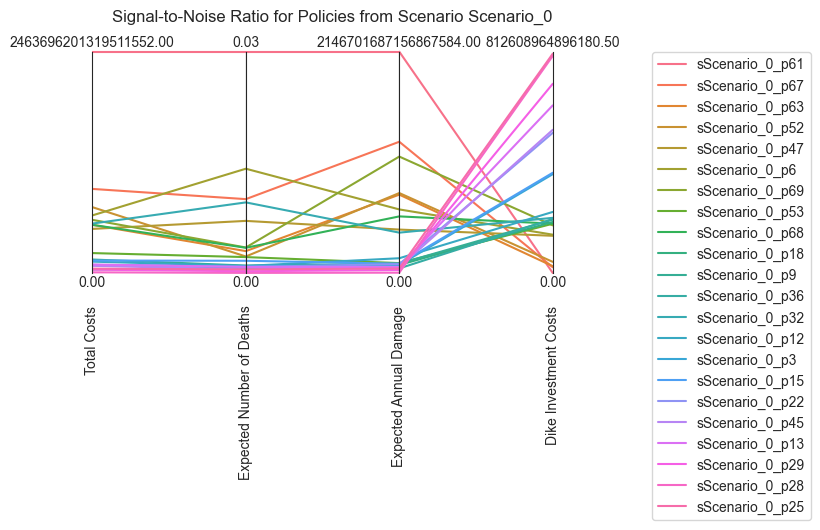

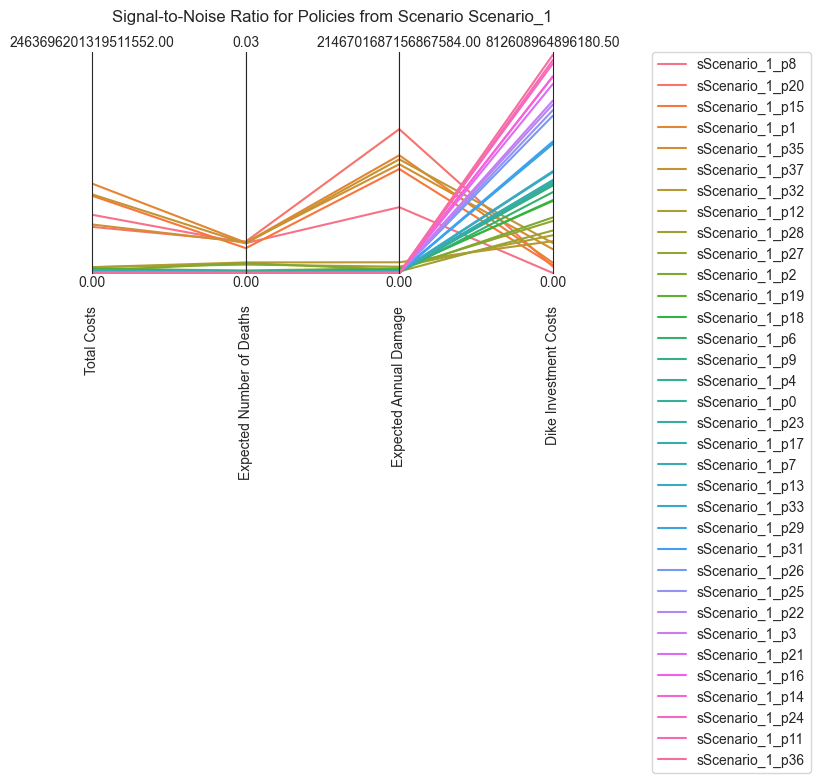

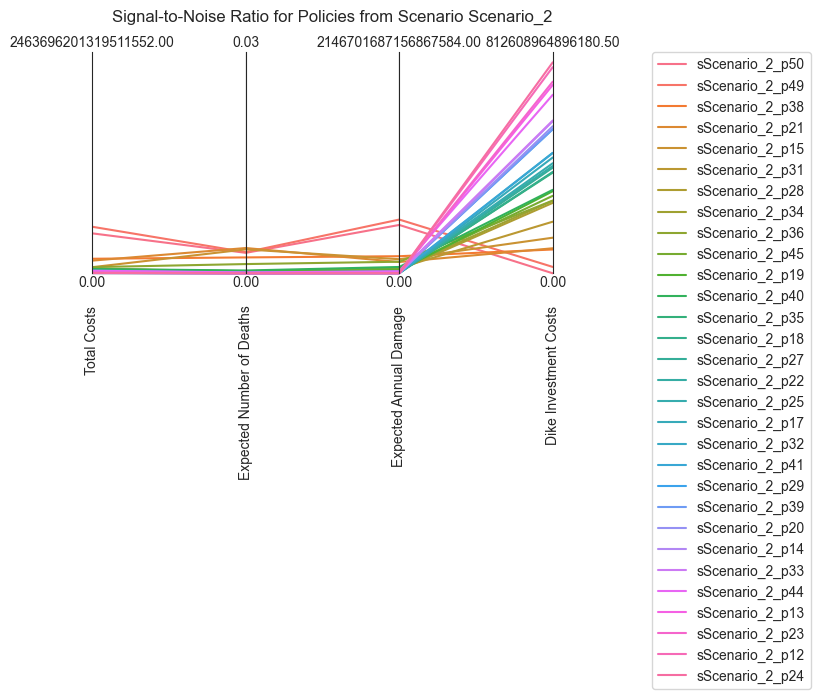

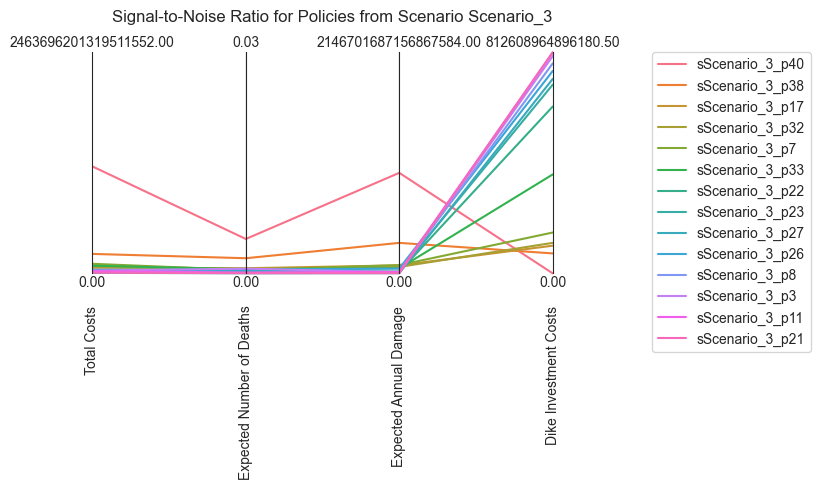

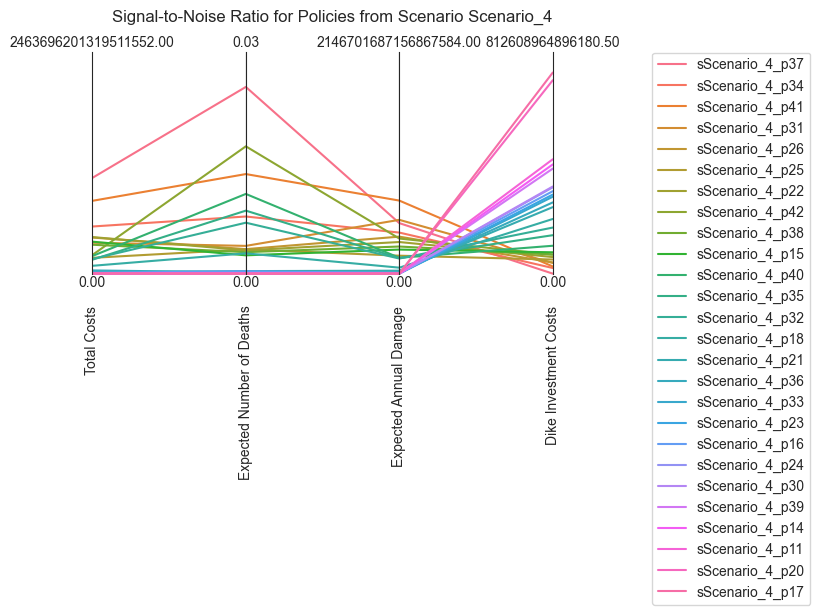

In [20]:
# Plotting
for count, scenario in enumerate(scenario_names):
    data = all_data[all_data['scenario'] == count]

    colors = sns.color_palette("husl", data.shape[0])
    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Signal-to-Noise Ratio for Policies from Scenario {scenario}', loc='right')
    plt.savefig(f'output/snr__top50_{scenario}_pairplot.png')
    plt.show()

After inspecting the visualizations above, the following conclusions were drawn:

Note that we are only looking within origin scenarios to easily (and visually) identify dominance within a smaller selection of the candidate policy set.

In terms of SNR, considering the combination of low total costs and low dike investment costs, and aiming to minimize the SNR:

In scenario Scenario_0, policies sScenario_0_p9, sScenario_0_p32, and sScenario_0_p3 have relatively low SNR for both total costs and dike investment costs. Among these, sScenario_0_p32 stands out for its balanced trade-offs across all outcomes.

In scenario Scenario_1, policies sScenario_1_p12, sScenario_1_p18, and sScenario_1_p9 show a good balance of low SNR for total costs and dike investment costs. Policy sScenario_1_p18 performs consistently well across the board.

In scenario Scenario_2, policies sScenario_2_p24, sScenario_2_p35, and sScenario_2_p2 demonstrate lower SNR in both cost dimensions. Policy sScenario_2_p35 provides the most balanced trade-offs.

In scenario Scenario_3, policies sScenario_3_p7, sScenario_3_p22, and sScenario_3_p9 exhibit the lowest SNR for the costs considered. Policy sScenario_3_p22 shows a notably balanced performance.

In scenario Scenario_4, policies sScenario_4_p11, sScenario_4_p33, and sScenario_4_p21 are identified with the lowest SNR across both total costs and dike investment costs. Policy sScenario_4_p33 offers the best balance among these.

# Maximum regret
in this part we will see what the effect is of selecting one policy over another. In order words, what is the regret I get for selecting policy A over policy B?



In [21]:
# Function to compute regret
def compute_regret(data, optimal):
    return np.abs(optimal - data)

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
import numpy as np

# Load your combined data
filepaths = [
    'output/optimization_policies_0.csv',
    'output/optimization_policies_1.csv',
    'output/optimization_policies_2.csv',
    'output/optimization_policies_3.csv',
    'output/optimization_policies_4.csv'
]

experiments_list = []
outcomes_list = []

for i, filepath in enumerate(filepaths):
    data = pd.read_csv(filepath)
    experiments = data.iloc[:, :16]
    outcomes = data.iloc[:, 16:]
    experiments['policy'] = [f'policy_{i}_{j}' for j in range(len(experiments))]
    experiments['scenario'] = f'Scenario_{i}'
    experiments_list.append(experiments)
    outcomes_list.append(outcomes)

experiments = pd.concat(experiments_list, ignore_index=True)
outcomes_combined = pd.concat(outcomes_list, ignore_index=True)

# Ensure the correct scenario keys
experiments['scenario'] = experiments['scenario'].apply(lambda x: x.replace('Scenario_Scenario_', 'Scenario_'))

# Split experiments into scenarios
experiments_by_scenario = {f'Scenario_{i}': df for i, df in experiments.groupby('scenario')}
outcomes_by_scenario = {f'Scenario_{i}': {col: outcomes_combined[col][experiments['scenario'] == f'Scenario_{i}'].values for col in outcomes_combined.columns} for i in range(len(filepaths))}

# Diagnostic prints
print("Keys in experiments_by_scenario:", experiments_by_scenario.keys())
print("Keys in outcomes_by_scenario:", outcomes_by_scenario.keys())

# Function to compute regret
def compute_regret(data, optimal):
    return np.abs(optimal - data)

# List of scenarios
scenarios = list(experiments_by_scenario.keys())

# Generate a DataFrame and plots of maximum regret metric per scenario
for scenario in scenarios:
    
    regrets_dict = {}
    max_regret_dict = {}
    
    for outcome_name in outcomes_combined.columns:
        scenario_experiments = experiments_by_scenario[scenario]
        scenario_outcomes = outcomes_by_scenario[scenario]
        
        # Create a DataFrame with relevant information
        data = pd.DataFrame({
            outcome_name: scenario_outcomes[outcome_name], 
            "policy": scenario_experiments['policy'],
            "scenario_id": scenario_experiments['scenario'],
        })
        
        # Filter out rows not corresponding to the selected policies based on SNR
        data = data[data['policy'].isin(remaining_policies)]

        # Reorient data for computing regret
        data = data.pivot(index='scenario_id', columns='policy')
        data.columns = data.columns.get_level_values(1)
        
        # Calculate the regret
        outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
        
        regrets_dict[outcome_name] = outcome_regret
        max_regret_dict[outcome_name] = outcome_regret.max()

    # Plot regret heatmap
    max_regret_df = pd.DataFrame(max_regret_dict)
    sns.heatmap(max_regret_df / max_regret_df.max(), cmap='viridis', annot=True)
    plt.title(f'Regret Heatmap for Policies from {scenario}')
    plt.savefig(f'output/regret__top50_{scenario}_heatmap.png')
    plt.show()

    # Plot regret pairplot
    data = max_regret_df

    limits = parcoords.get_limits(data)
    limits.loc[0, outcomes_of_interest] = 0

    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        colors = sns.color_palette("husl", data.shape[0])
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Maximum Regrets per Outcome in {scenario}', loc='right')
    plt.savefig(f'output/regret__top50_{scenario}_pairplot.png')
        
    plt.show()


Keys in experiments_by_scenario: dict_keys(['Scenario_Scenario_0', 'Scenario_Scenario_1', 'Scenario_Scenario_2', 'Scenario_Scenario_3', 'Scenario_Scenario_4'])
Keys in outcomes_by_scenario: dict_keys(['Scenario_0', 'Scenario_1', 'Scenario_2', 'Scenario_3', 'Scenario_4'])


KeyError: 'Scenario_Scenario_0'

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

# Function to compute regret
def compute_regret(data, optimal):
    return np.abs(optimal - data)

# Load the combined policies and outcomes data
combined_policies_df = pd.read_csv('output/combined_optimization_outcomes.csv')

# Separate experiments and outcomes
experiments = combined_policies_df.iloc[:, :16]
outcomes_combined = combined_policies_df.iloc[:, 16:]

# Initialize dictionaries to hold experiments and outcomes by scenario
experiments_by_scenario = {}
outcomes_by_scenario = {}

# Create separate dataframes for each scenario
scenarios = combined_policies_df['Original Scenario'].unique()
for scenario in scenarios:
    scenario_experiments = combined_policies_df[combined_policies_df['Original Scenario'] == scenario]
    experiments_by_scenario[scenario] = scenario_experiments.iloc[:, :16]
    outcomes_by_scenario[scenario] = scenario_experiments.iloc[:, 16:]

# Define the outcomes of interest
outcomes_of_interest = ['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs']

# Manually define the ScalarOutcome class
class ScalarOutcome:
    MINIMIZE = "MINIMIZE"
    MAXIMIZE = "MAXIMIZE"

# Simulate the "model" outcomes
model_outcomes = [ScalarOutcome(name, ScalarOutcome.MINIMIZE) for name in outcomes_of_interest]

# Generate a DataFrame and plots of maximum regret metric per scenario
for scenario in scenarios:
    
    regrets_dict = {}
    max_regret_dict = {}
    
    for outcome in model_outcomes:
        scenario_experiments = experiments_by_scenario[scenario]
        scenario_outcomes = outcomes_by_scenario[scenario]
        
        # Create a DataFrame with relevant information
        data = pd.DataFrame({
            outcome.name: scenario_outcomes[outcome.name], 
            "policy": scenario_experiments.index,
            "scenario_id": scenario_experiments.index,
        })
        
        # Filter out rows not corresponding to the selected policies based on SNR
        data = data[data['policy'].isin(scenario_experiments.index)]

        # Reorient data for computing regret
        data = data.pivot(index='scenario_id', columns='policy')
        data.columns = data.columns.get_level_values(1)
        
        # Calculate the regret
        outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
        
        regrets_dict[outcome.name] = outcome_regret
        max_regret_dict[outcome.name] = outcome_regret.max()

    # Plot regret heatmap
    max_regret_df = pd.DataFrame(max_regret_dict)
    sns.heatmap(max_regret_df / max_regret_df.max(), cmap='viridis', annot=True)
    plt.title(f'Regret Heatmap for Policies from {scenario}')
    plt.show()

    # Plot regret pairplot
    data = max_regret_df

    limits = parcoords.get_limits(data)
    limits.loc[0, outcomes_of_interest] = 0

    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        colors = sns.color_palette("husl", data.shape[0])
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Maximum Regrets per Outcome in {scenario}', loc='right')
    plt.show()


TypeError: ScalarOutcome() takes no arguments

Experiments columns in reference_0: Index(['Total Costs'], dtype='object')
Outcomes columns in reference_0: Index(['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage',
       'Dike Investment Costs'],
      dtype='object')
Experiments columns in reference_1: Index(['Total Costs'], dtype='object')
Outcomes columns in reference_1: Index(['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage',
       'Dike Investment Costs'],
      dtype='object')
Experiments columns in reference_2: Index(['Total Costs'], dtype='object')
Outcomes columns in reference_2: Index(['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage',
       'Dike Investment Costs'],
      dtype='object')
Experiments columns in reference_3: Index(['Total Costs'], dtype='object')
Outcomes columns in reference_3: Index(['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage',
       'Dike Investment Costs'],
      dtype='object')
Experiments columns in reference_4: Inde

C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


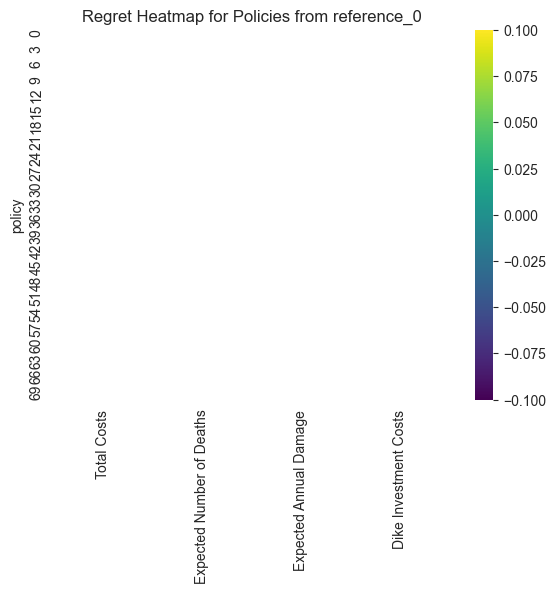

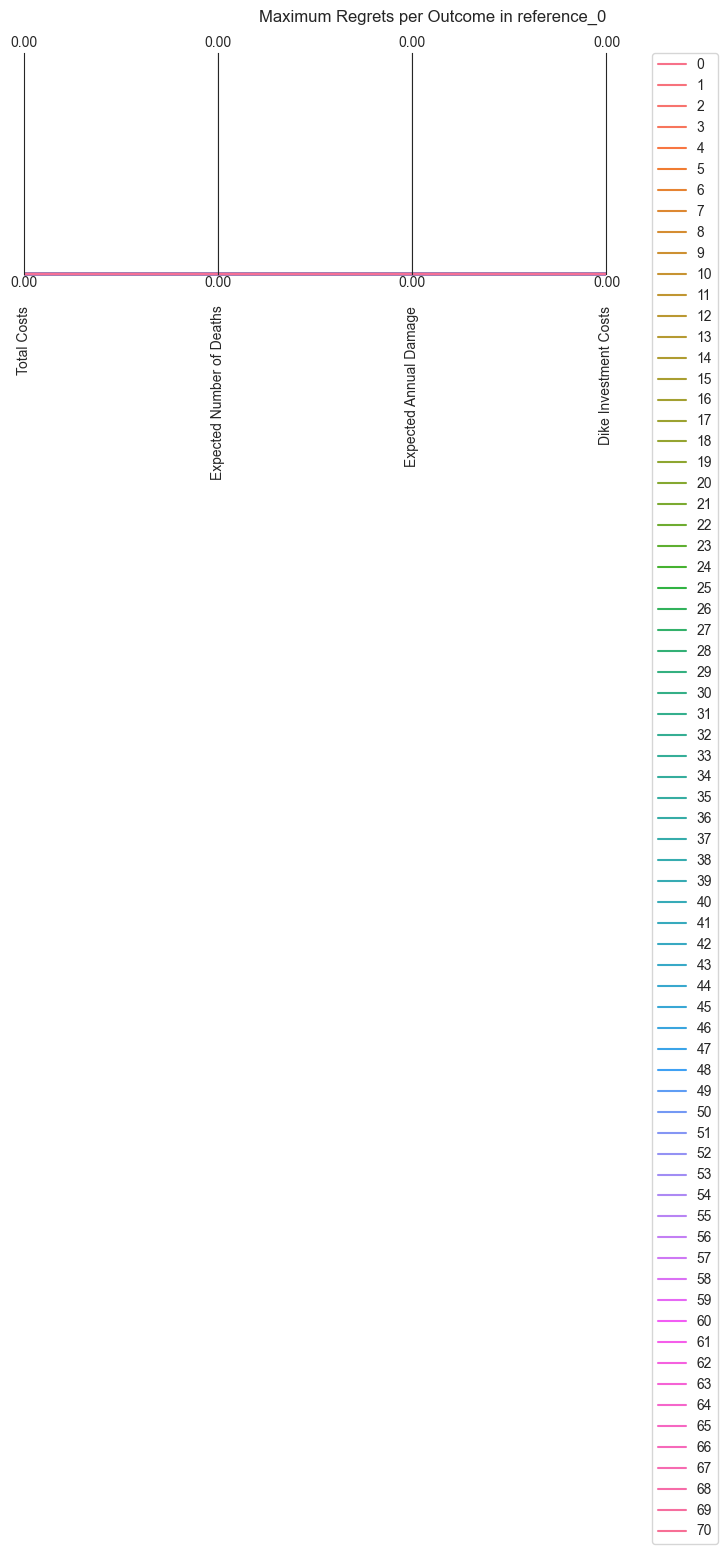

C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


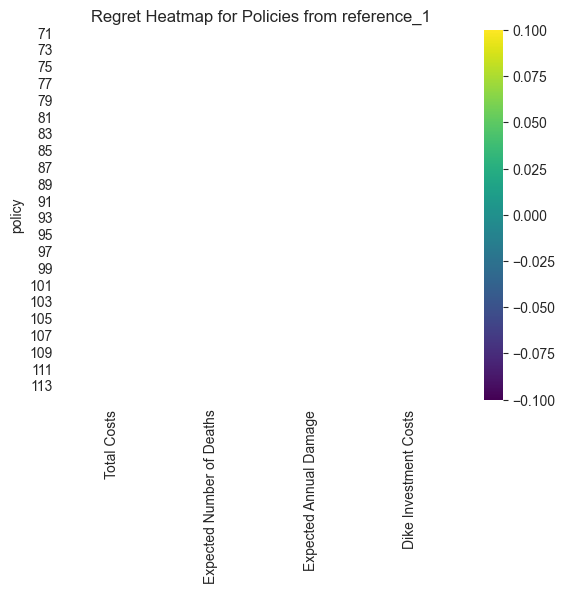

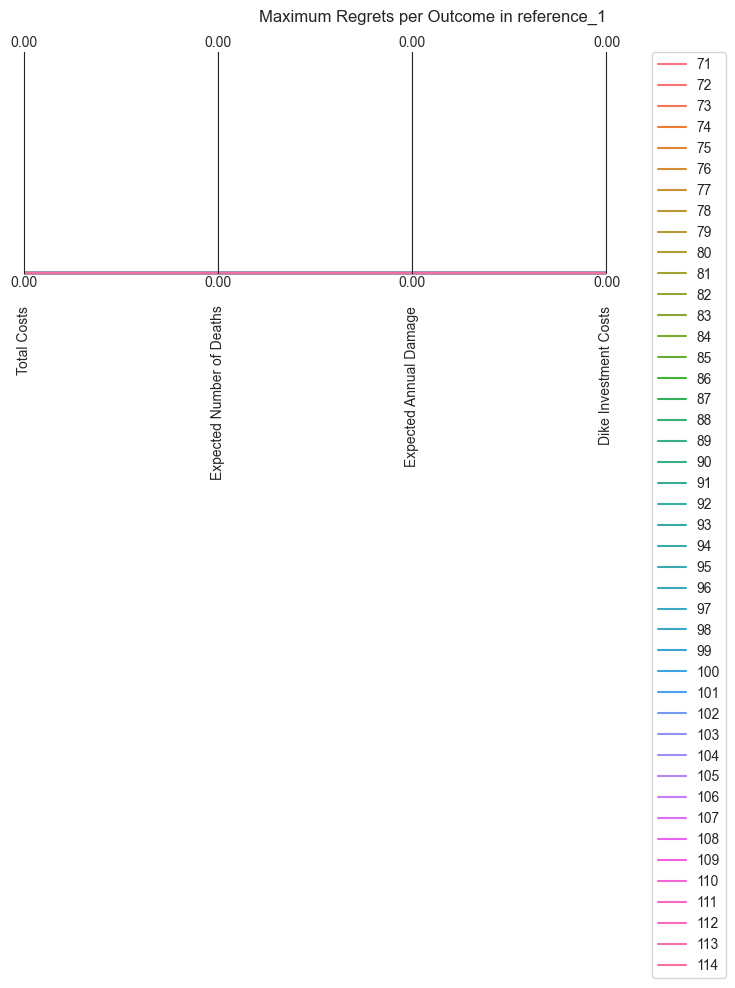

C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


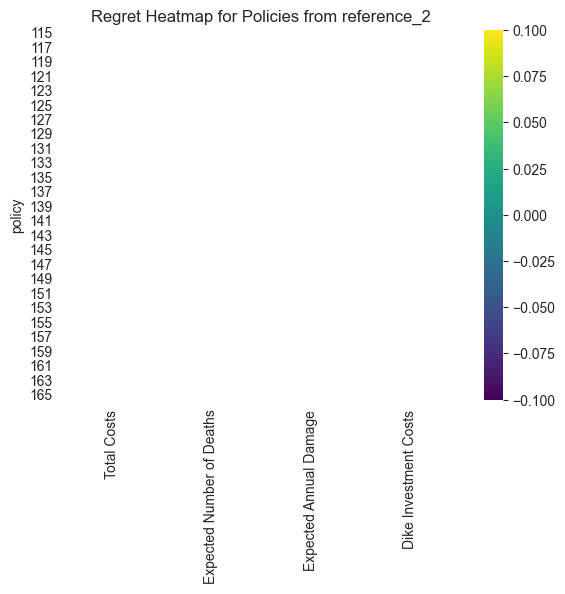

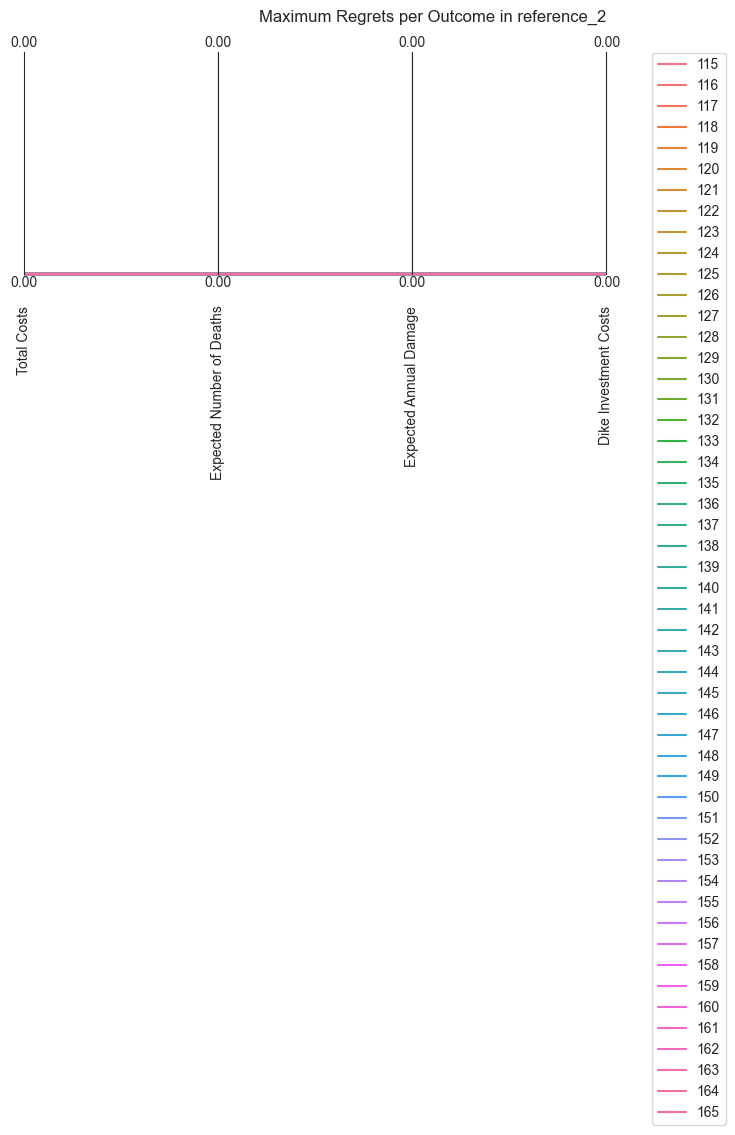

C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


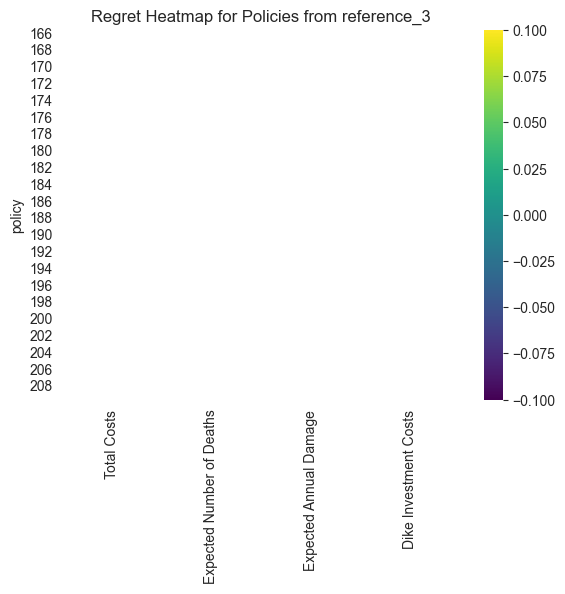

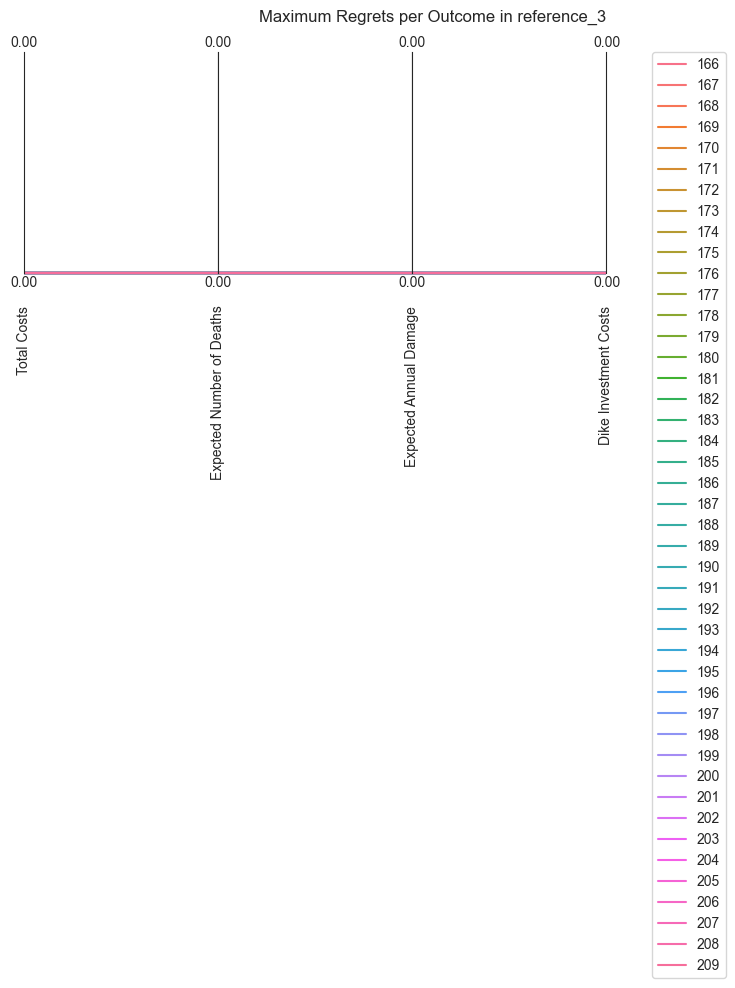

C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Joost\PycharmProjects\venv\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


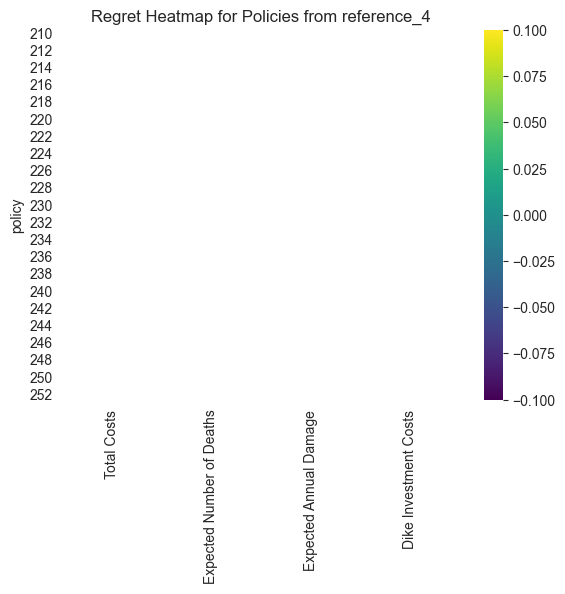

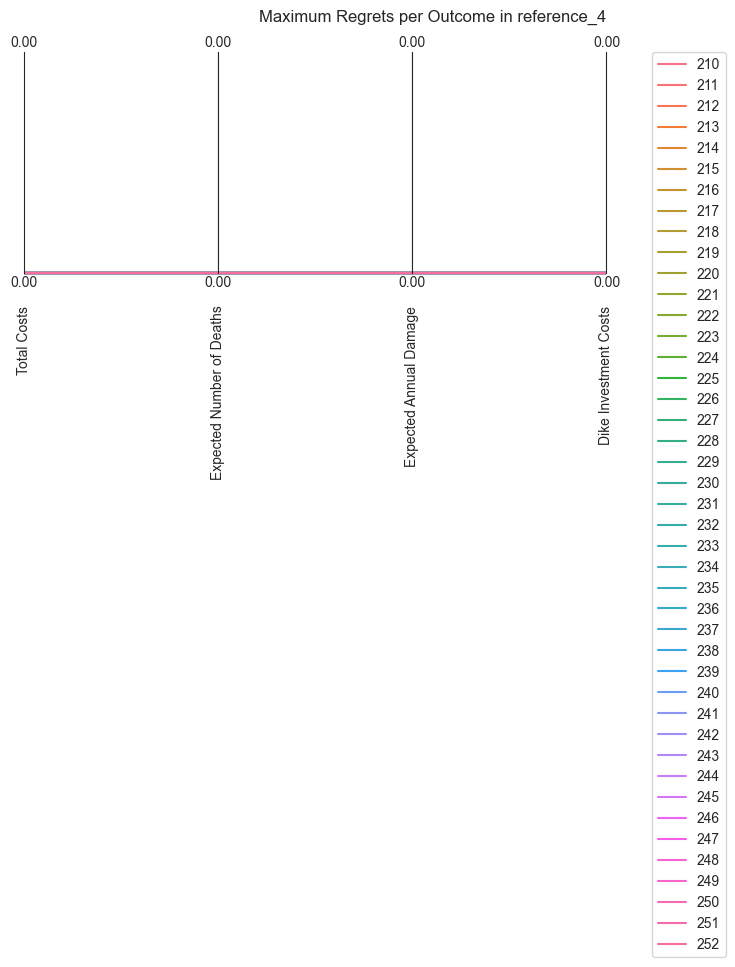

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

# Function to compute regret
def compute_regret(data, optimal):
    return np.abs(optimal - data)

# Load the combined policies and outcomes data
combined_policies_df = pd.read_csv('output/combined_optimization_outcomes.csv')

# Define the outcomes of interest
outcomes_of_interest = ['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs']

# Separate experiments and outcomes
experiments = combined_policies_df.iloc[:, :-5]
outcomes_combined = combined_policies_df[outcomes_of_interest]

# Initialize dictionaries to hold experiments and outcomes by scenario
experiments_by_scenario = {}
outcomes_by_scenario = {}

# Create separate dataframes for each scenario
scenarios = combined_policies_df['Original Scenario'].unique()
for scenario in scenarios:
    scenario_experiments = combined_policies_df[combined_policies_df['Original Scenario'] == scenario]
    experiments_by_scenario[scenario] = scenario_experiments.iloc[:, :-5]
    outcomes_by_scenario[scenario] = scenario_experiments[outcomes_of_interest]

# Verify the data separation
for scenario in scenarios:
    print(f"Experiments columns in {scenario}:", experiments_by_scenario[scenario].columns)
    print(f"Outcomes columns in {scenario}:", outcomes_by_scenario[scenario].columns)

# Manually define the ScalarOutcome class
class ScalarOutcome:
    MINIMIZE = "MINIMIZE"
    MAXIMIZE = "MAXIMIZE"

    def __init__(self, name, kind):
        self.name = name
        self.kind = kind

# Simulate the "model" outcomes
model_outcomes = [ScalarOutcome(name, ScalarOutcome.MINIMIZE) for name in outcomes_of_interest]

# Generate a DataFrame and plots of maximum regret metric per scenario
for scenario in scenarios:
    
    regrets_dict = {}
    max_regret_dict = {}
    
    for outcome in model_outcomes:
        scenario_experiments = experiments_by_scenario[scenario]
        scenario_outcomes = outcomes_by_scenario[scenario]
        
        # Create a DataFrame with relevant information
        data = pd.DataFrame({
            outcome.name: scenario_outcomes[outcome.name], 
            "policy": scenario_experiments.index,
            "scenario_id": scenario_experiments.index,
        })
        
        # Filter out rows not corresponding to the selected policies based on SNR
        data = data[data['policy'].isin(scenario_experiments.index)]

        # Reorient data for computing regret
        data = data.pivot(index='scenario_id', columns='policy')
        data.columns = data.columns.get_level_values(1)
        
        # Calculate the regret
        outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
        
        regrets_dict[outcome.name] = outcome_regret
        max_regret_dict[outcome.name] = outcome_regret.max()

    # Plot regret heatmap
    max_regret_df = pd.DataFrame(max_regret_dict)
    sns.heatmap(max_regret_df / max_regret_df.max(), cmap='viridis', annot=True)
    plt.title(f'Regret Heatmap for Policies from {scenario}')
    plt.show()

    # Plot regret pairplot
    data = max_regret_df

    limits = parcoords.get_limits(data)
    limits.loc[0, outcomes_of_interest] = 0

    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        colors = sns.color_palette("husl", data.shape[0])
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Maximum Regrets per Outcome in {scenario}', loc='right')
    plt.show()
